# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [32]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

sudo: The "no new privileges" flag is set, which prevents sudo from running as root.
sudo: If sudo is running in a container, you may need to adjust the container configuration to disable the flag.


In [ ]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [11]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [12]:
env = gym.make('BoxingDeterministic-v4')
state = env.reset()

In [13]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 18 #fire, left, and right          noop, left and right for skiing

/opt/conda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [14]:
double_dqn = True # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [15]:
print(train_frame, learning_rate, EPISODES)

400000 0.0001 3000


In [16]:
# continue from previous training
# agent.policy_net = torch.load("./save_model/breakout_dqn_latest_3.6.pth")

episode: 0   score: -6.0   memory length: 1786   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -6.0
episode: 1   score: -1.0   memory length: 3572   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -3.5
episode: 2   score: -10.0   memory length: 5358   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -5.666666666666667
episode: 3   score: -4.0   memory length: 7144   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -5.25
episode: 4   score: -1.0   memory length: 8930   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -4.4
episode: 5   score: 2.0   memory length: 10716   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -3.3333333333333335
episode: 6   score: 1.0   memory length: 12502   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -2.7142857142857144
episode: 7   score: -4.0   memory length: 14288   epsilon: 1.0    steps: 1786    lr: 0.0001     evaluation reward: -2.875

/home/jhui8/cs444/assignment5/memory.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample, dtype=object)


episode: 223   score: 4.0   memory length: 400064   epsilon: 0.9999356500000014    steps: 1786    lr: 0.0001     evaluation reward: 0.02


/home/jhui8/cs444/assignment5/agent_double.py:75: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  mini_batch = np.array(mini_batch, dtype=object).transpose()


episode: 224   score: -4.0   memory length: 401850   epsilon: 0.9981675100000398    steps: 1786    lr: 0.0001     evaluation reward: -0.01
episode: 225   score: -5.0   memory length: 403636   epsilon: 0.9963993700000782    steps: 1786    lr: 0.0001     evaluation reward: -0.05
episode: 226   score: 10.0   memory length: 405422   epsilon: 0.9946312300001166    steps: 1786    lr: 0.0001     evaluation reward: 0.05
episode: 227   score: -1.0   memory length: 407208   epsilon: 0.9928630900001549    steps: 1786    lr: 0.0001     evaluation reward: -0.02
episode: 228   score: -2.0   memory length: 408994   epsilon: 0.9910949500001933    steps: 1786    lr: 0.0001     evaluation reward: -0.02
episode: 229   score: 2.0   memory length: 410780   epsilon: 0.9893268100002317    steps: 1786    lr: 0.0001     evaluation reward: 0.22
episode: 230   score: 4.0   memory length: 412566   epsilon: 0.9875586700002701    steps: 1786    lr: 0.0001     evaluation reward: 0.3
episode: 231   score: 8.0   memor

KeyboardInterrupt: 

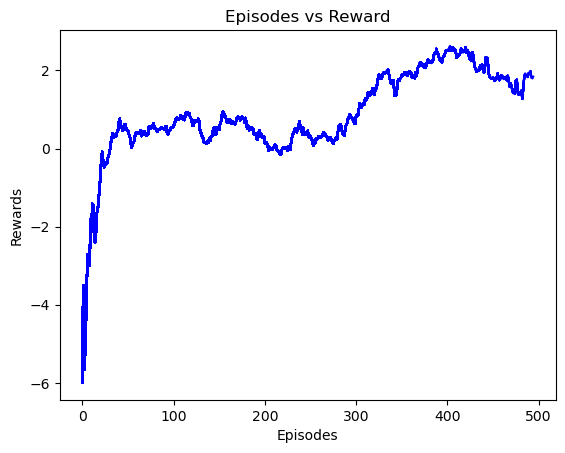

In [17]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, truncated, info = env.step(action)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            if not double_dqn and frame % agent.update_target == 0:
                agent.update_targetnet()
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/skiing_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            if e % 1 == 0:
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                      "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/skiing_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


In [55]:
print(frame)

1287


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [28]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_8.pth")

In [30]:
# from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
from gym.wrappers import RecordVideo
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [33]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()

FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb'